In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from numpy.fft import fft, ifft, fftfreq
from scipy import signal
from astropy.stats import LombScargle
from nfft import ndft, nfft, ndft_adjoint, nfft_adjoint
from gatspy.periodic import LombScargleFast
import time
import pdb
plt.style.use('seaborn')

In [2]:
help(LombScargle.autopower)

Help on function autopower in module astropy.stats.lombscargle.core:

autopower(self, method='auto', method_kwds=None, normalization=None, samples_per_peak=5, nyquist_factor=5, minimum_frequency=None, maximum_frequency=None)
    Compute Lomb-Scargle power at automatically-determined frequencies.
    
    Parameters
    ----------
    method : string (optional)
        specify the lomb scargle implementation to use. Options are:
    
        - 'auto': choose the best method based on the input
        - 'fast': use the O[N log N] fast method. Note that this requires
          evenly-spaced frequencies: by default this will be checked unless
          ``assume_regular_frequency`` is set to True.
        - 'slow': use the O[N^2] pure-python implementation
        - 'cython': use the O[N^2] cython implementation. This is slightly
          faster than method='slow', but much more memory efficient.
        - 'chi2': use the O[N^2] chi2/linear-fitting implementation
        - 'fastchi2': use 

## SNR para datos equiespaciados

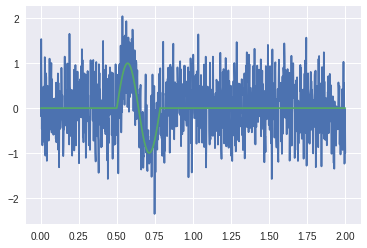

In [5]:
# sinusoidal signal
def signal_equip(N):
    dt = 2 / N
    t = np.linspace(0, N * dt, N)
    t = t + dt
#     print("min of t: ", min(t))
    temp = np.zeros(N)
    segment_duration = int(N/7)
    freq_sin = 1 / (segment_duration * dt)
#     print("choosen freq is: ", freq_sin)
    temp[int(N/4): int(N/4) + segment_duration] = np.sin(freq_sin * 2 * np.pi * t[:segment_duration])
    return temp, freq_sin, dt, t

# set data
# np.random.seed(13241)
N = 1024  # should be even for simplicity
temp, freq_sin, dt, t = signal_equip(N)
data = np.random.normal(0, 0.6, N) + temp
plt.plot(t, data)
plt.plot(t, temp)

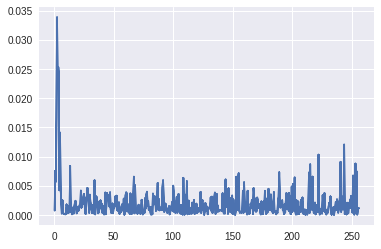

In [6]:
# obtencion de la psd usando las frequencias de numpy.fft
def get_scipy_psd(N, dt, t, data):
    freqs = fftfreq(N, d=dt)
    freqs_abs = np.abs(freqs)
    freqs_lomb = np.delete(freqs_abs, 0)
    pgram_fft = signal.lombscargle(t, data, freqs_lomb * 2 * np.pi, normalize=True)
    return freqs_lomb, pgram_fft

freqs_lomb, pgram_fft = get_scipy_psd(N, dt, t, data)
plt.plot(freqs_lomb, pgram_fft)

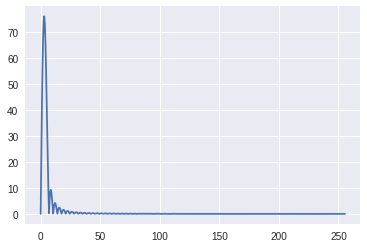

In [7]:
# las fft
def get_fft(N, temp, data):
    dwindow = signal.tukey(len(temp), alpha=1./8)
    # pgram = np.mean(pgram)
    fft_d = fft(dwindow * data)
    fft_t = fft(dwindow * temp)
    return fft_d, fft_t

fft_d, fft_t = get_fft(N, temp, data)
freqs = fftfreq(N, d=dt)
plt.plot(freqs[:int(N/2)], np.abs(fft_t[:int(N/2)]))

In [8]:
# realizando una pequeña revision del teorema de parseval
sum_time = (np.abs(temp)**2).sum()
sum_freq = (np.abs(fft_t)**2).sum()
print(sum_time, sum_freq/N)
# vemos que coincide cuando dividimos la suma en frequencias por N, esto es dividir las frequencias por raiz de N
sum_freq = (np.abs(fft_t/np.sqrt(N))**2).sum()
print(sum_time, sum_freq/N)
print("\n ------------ \n")

# aprovechemos de revisar la invera
temp_inv = ifft(fft_t)
sum_time_inv = (np.abs(temp_inv)**2).sum()
print(sum_time, sum_time_inv)
# vemos que en la inversa se corrige esto, si por otro lado a la inversa le ingreso una fft dividida por sqrt(N)
temp_inv = ifft(fft_t/np.sqrt(N))
sum_time_inv = (np.abs(temp_inv)**2).sum()
print(sum_time, sum_time_inv*N)
# se hace necesario multiplicar por raiz de N, esto es claro por que las constantes en fourier se puede sacar.
# luego si el objetivo final es aplicar ifft de fft no es necesario normalizar

72.9287753976131 72.9287753976131
72.9287753976131 0.07121950722423154

 ------------ 

72.9287753976131 72.9287753976131
72.9287753976131 72.9287753976131


3.45050221926593 12.069363661161129


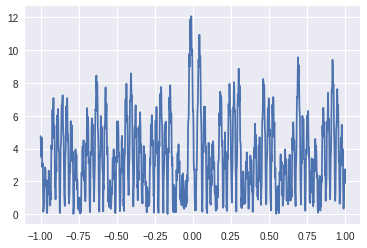

In [10]:
#las fft
def snr_equip(N, only_noise=False):
    temp, freq_sin, dt, t = signal_equip(N)
    if only_noise:
        data = np.random.normal(0, 0.6, N)
    else:
        data = np.random.normal(0, 0.6, N) + temp
        
    freqs_lomb, pgram_fft = get_scipy_psd(N, dt, t, data)
    dwindow = signal.tukey(len(temp), alpha=1./8)
    # pgram = np.mean(pgram)
    fft_d = fft(dwindow * data)
    fft_t = fft(dwindow * temp)
    fft_d = np.delete(fft_d, 0) # remving the value corresponding to 0 frequency
    fft_t = np.delete(fft_t, 0)
    
    df = 2 / (N * dt)
    norm_sigma = 4 * df
    h_norm = (fft_t * fft_t.conjugate() / pgram_fft).sum()
    norm_corr = 4 * df / np.sqrt(h_norm.real * norm_sigma)
    corr = fft_d * fft_t.conjugate() / pgram_fft
    snr = ifft(corr) * norm_corr * dt * (len(fft_d) - 1)
    snr = np.roll(snr, len(snr) // 2)
    return t, np.abs(snr) 

N = 1024
t, snr = snr_equip(N, only_noise=False)# 
plt.figure(2)
t = np.delete(t, len(t)-1)
plt.plot(t - t[len(t)//2], snr)
print(np.mean(snr), max(snr))


In [11]:
# analicemos el error asociado a muchas repeticiones
def repeat_snr(N, n_repeat, only_noise=False):
    mean_snr = []
    max_snr = []
    median_snr = []
    std_snr = []
    for i in range(n_repeat):
        _, snr = snr_equip(N, only_noise=only_noise)
        mean_snr.append(np.mean(snr))
        median_snr.append(np.median(snr))
        max_snr.append(np.max(snr))
        std_snr.append(np.std(snr))
    return mean_snr, median_snr, max_snr, std_snr

rep = 100
mean, median, maxx, stdd = repeat_snr(1024, rep, only_noise=True)
print(":::::SNR parameters for {} repetitions for signal of only noise:::::".format(rep))
print("mean snr over is: {} +- {}".format(np.mean(mean), np.std(mean)))
print("median snr is: {} +- {}".format(np.mean(median), np.std(median)))
print("max snr is: {} +- {}".format(np.mean(maxx),np.std(maxx)))
print("std snr is: {} +- {}".format(np.mean(stdd),np.std(stdd)))
print("\n -------------------------- \n")
mean, median, maxx, stdd = repeat_snr(1024, rep, only_noise=False)
print(":::::SNR parameters for {} repetitions for signal of noise + template:::::".format(rep))
print("mean snr over is: {} +- {}".format(np.mean(mean), np.std(mean)))
print("median snr is: {} +- {}".format(np.mean(median), np.std(median)))
print("max snr is: {} +- {}".format(np.mean(maxx),np.std(maxx)))
print("std snr is: {} +- {}".format(np.mean(stdd),np.std(stdd)))

:::::SNR parameters for 100 repetitions for signal of only noise:::::
mean snr over is: 2.0406839053997436 +- 1.487458175621833
median snr is: 1.9515620154726343 +- 1.675356064947864
max snr is: 5.342890858188111 +- 2.5242290477948828
std snr is: 1.280339717234427 +- 0.7009788518861841

 -------------------------- 

:::::SNR parameters for 100 repetitions for signal of noise + template:::::
mean snr over is: 2.5512071192605106 +- 2.417567960146879
median snr is: 2.363558511556987 +- 2.717964682761761
max snr is: 10.111631967960932 +- 3.909980652510863
std snr is: 1.829630607385346 +- 1.055720142221268


# SNR para datos no equiespaciados

11.630730257342643


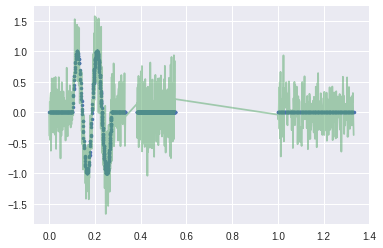

In [12]:
def signal_no_equip(N, fixed=True):
    # 3 parts separated in time, one with slight irregularities in time sampling
    # another with change of spacing and the last one with big outlier in spacing
    T = np.zeros(N)
    dt_implicit = 1 / N
    t0 = np.linspace(0, 2*int(N/6)-1, 2*int(N/6))
    if fixed:
        np.random.seed(1)
    e = np.random.normal(0, dt_implicit * 0.5, 2*int(N/6))
    T[0:2*int(N/6)] = t0 * dt_implicit + e
    shift = 30 * dt_implicit
    
    if fixed:
        np.random.seed(2)
    t0 = np.linspace(2*int(N/6), 3*int(N/6)-1, int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, int(N/6))
    T[2*int(N/6):3*int(N/6)] = shift + t0 * dt_implicit / 2 + e
    
    if fixed:
        np.random.seed(3)
    t0 = np.linspace(3*int(N/6), 4*int(N/6)-1, int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, int(N/6))
    T[3*int(N/6):4*int(N/6)] = t0 * 2 * dt_implicit + e
    
    if fixed:
        np.random.seed(4)
    t0 = np.linspace(4*int(N/6), N-1, N - 4*int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, N - 4*int(N/6))
    T[4*int(N/6):N] = 2 * shift + t0 * dt_implicit / 2 + e
    T.sort()

    #  signal is sinusoidal again with same frequency
    temp = np.zeros(N)
    segment_duration = int(N/3)
    init = int(N/10)
    times_segment = T[init: init + segment_duration]
    times_segment = times_segment - min(times_segment)
    freq_sin = 2 / (max(times_segment) - min(times_segment))
#     print("choosen freq is: ", freq_sin)
    temp[init: init + segment_duration] = np.sin(freq_sin * 2 * np.pi * times_segment)
    return temp, freq_sin, T
N = 1200
temp2, freq_sin, t2 = signal_no_equip(N, fixed=False)
print(freq_sin)
data2 = np.random.normal(0, 0.3, N) + temp2
plt.plot(t2, temp2, '.')
plt.plot(t2, data2, alpha=0.5)

mean value of the PSD:  0.002959130364039871 or  0.002967941009182858


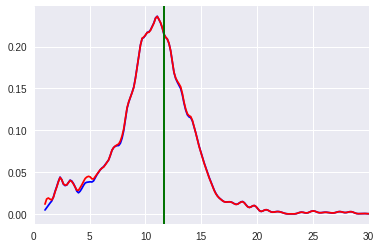

In [14]:
# obtencion de la psd dejando que calcule sus propias frequencias
df = 1 / (max(t2) - min(t2))
freqs = fftfreq(N, d=1/df)
freqs_lomb = np.delete(np.abs(freqs), 0)

frequency, power = LombScargle(t2, data2).autopower(maximum_frequency=1000, minimum_frequency=1)
pgram = signal.lombscargle(t2, data2, frequency * 2 * np.pi, normalize=True)
print("mean value of the PSD: ", np.mean(pgram), "or ", np.mean(power))
plt.figure(1)
plt.plot(frequency, pgram, "b")
plt.plot(frequency, power, 'r')
plt.axvline(freq_sin, color='k')
plt.axvline(freq_sin, color='g')
plt.xlim([0, 30])
plt.show()

# se obtiene resultados similares pero sabemos que astropy lo implementa en tiempo O(Nlog(N)) y scypy en tiempo O(N^2)

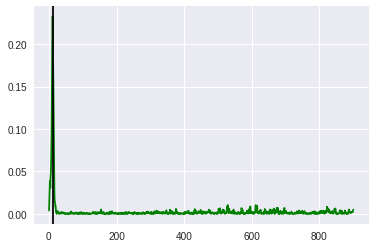

In [15]:
# NF viene de -(Nf // 2) + np.arange(Nf)
def get_psd(k, t, data, min_freq=None, data_per_peak=1):
    df = 1 / ((max(t) - min(t)) * data_per_peak)
    if min_freq is None:
        min_freq = 0.5 * df
    NK = len(k)
    if NK % 2 == 0: # par
        N = int(NK / 2)
    else:
        N = int((NK-1) / 2)
    
    max_freq = (N - 1) * df + min_freq
    
    frequency, power = LombScargle(t, data).autopower(maximum_frequency=max_freq, minimum_frequency=min_freq,
                                                     samples_per_peak=data_per_peak)
    if len(frequency) != N:
        raise ValueError("algo malo")
    
    return frequency, power, df
Nf = 2 * N
k = -(Nf // 2) + np.arange(Nf)
freqs, pw, df = get_psd(k, t2, data2)
plt.plot(freqs, pw, 'g')
plt.axvline(freq_sin, color='k')
# plt.xlim([0, 30])

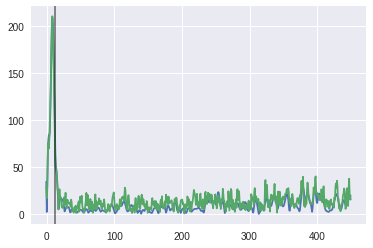

In [42]:
# calcula las nfft
def get_nfft(Nf, data, temp, t):
    dwindow = signal.tukey(len(temp), alpha=1./8)
    
    nfft_d = nfft_adjoint(t, dwindow * data, Nf)
    nfft_t = nfft_adjoint(t, dwindow * temp, Nf)
    k = -(Nf // 2) + np.arange(Nf)
    return nfft_d, nfft_t, k
Nf = N
nfft_d, nfft_t, k = get_nfft(Nf, data2, temp2, t2)
plt.plot(k[Nf//2-1:] * df, np.abs(nfft_t[Nf//2-1:]))
plt.plot(k[Nf//2-1:] * df, np.abs(nfft_d[Nf//2-1:]))
plt.axvline(freq_sin, color='k', alpha=0.5)

1.0


/home/pancho/.local/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


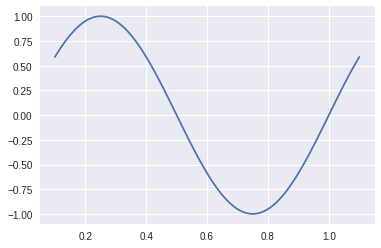

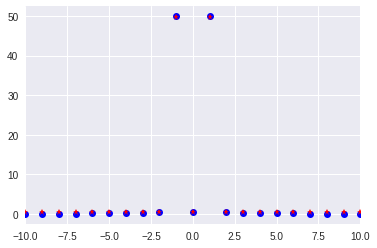

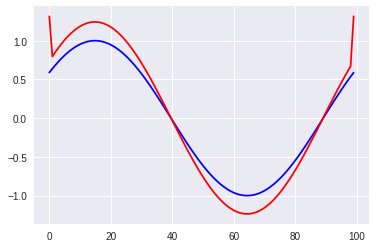

In [140]:
t = np.linspace(0.1, 1.1, 100)
freqq = 1 / (max(t) - min(t))
print(freqq)
d = np.sin(2 * np.pi * freqq * t)
plt.figure()
plt.plot(t, d)
nfft_freqs = (-(2*len(t)//2) + np.arange(2 * len(t))) / (max(t) - min(t))
fft_freqs = fftfreq(len(t), d=((max(t) - min(t)) / len(t)))
fft_d_test = fft(d)
nfft_d_test = nfft_adjoint(t, d, 2*len(t))
plt.figure()
plt.plot(fft_freqs, np.abs(fft_d_test), 'bo')
plt.plot(nfft_freqs, np.abs(nfft_d_test), 'r*')
plt.xlim([-10, 10])

# erase 0 frequency
# fft_d_test = np.delete(fft_d_test, 0)
# nfft_d_test = np.delete(fft_d_test, (2 * len(t))//2)
         
dy = ifft(fft_d_test)
dyy = nfft(t, nfft_d_test) / (2*len(t))
plt.figure()
plt.plot(dy, 'b')
plt.plot(dyy, 'r')

/home/pancho/.local/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


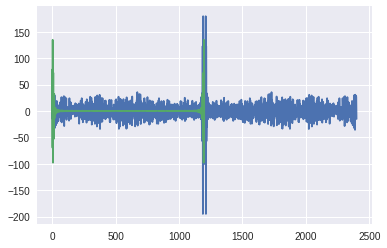

In [30]:
nfft_d, nfft_t, k = get_nfft(Nf, data2, temp2, t2)
fft_d, fft_t = get_fft(N, data2, temp2)
plt.plot(nfft_d)
plt.plot(fft_d)

In [66]:
# realizando una pequeña comprobacion del teorema de parseval
sum_time = (np.abs(temp2)**2).sum()
sum_freq = (np.abs(nfft_t)**2).sum()
print(sum_time, sum_freq / np.sqrt(2 * Nf))

# vemos que no se cumple parseval, esto era esperable dado 
#que aplicamos muchas mas frequencias que tiempos, para la inversa

dwindow = signal.tukey(len(temp2), alpha=1./8)
temp_back = nfft(t2, nfft_t)
sum_time_back = (np.abs(temp_back)**2).sum()
print(sum_time, sum_time_back / (2 * Nf) )
print("-------")

# vemos entonces que parseval no se cumple, por otro lado si usamos una matriz 
#cuadrada, i.e, misma cantidad de freqs que tiempos nos da:
Nf_test = N
nfft_d_test, nfft_t_test, k_test = get_nfft(Nf_test, data2, temp2, t2)
sum_freq = (np.abs(nfft_t_test)**2).sum()
print(sum_time, sum_freq / N)
temp_back = nfft(t2, nfft_t_test)
sum_time_back = (np.abs(temp_back)**2).sum()
print(sum_time, sum_time_back)

# vemos que tampoco se cumple incluso aplicamos la misma cantidad de frequencias que tiempos, esto nos dice que aun
# si se aplican igual frequencias, dado que los tiempos varias, no hay garantia de que la matriz sea invertible.
# por otro lado puede que el teorema de parseval no se aplique aqui.

206.25883816372993 14914.4828492587
206.25883816372993 1438885.842067231
-------
206.25883816372993 3098.2554178016353
206.25883816372993 2459189388.420291


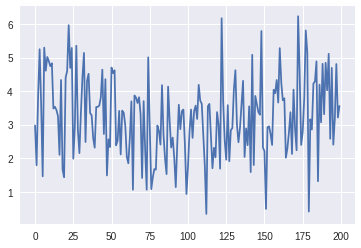

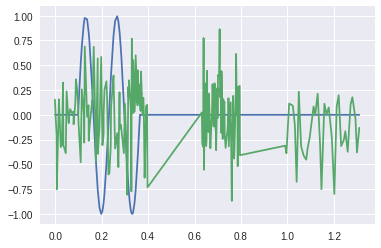

In [143]:
# el snr de los no espaciados
def snr_no_equip(N, only_noise=False, fixed=False):
    temp, freq_sin, t = signal_no_equip(N, fixed=fixed)
    if only_noise:
        if fixed:
            np.random.seed(12312)
        data = np.random.normal(0, 0.3, N)
    else:
        data = np.random.normal(0, 0.3, N) + temp
    
    # calcula la psd
    Nf = 4 * N
    k = -(Nf // 2) + np.arange(Nf)
    freqs, pw, df = get_psd(k, t, data)
    
    # repite la psd para obtener los datos con frequencias negativas, si Nf es par entonces el ultimo no se repite
    pw = np.append(pw, pw)
    if Nf % 2 == 0:
        pw = np.delete(pw, len(pw) - 1)
    
    nfft_d, nfft_t, k = get_nfft(Nf, data, temp, t)
    nfft_d = np.delete(nfft_d, 0) # remving the value corresponding to 0 frequency
    nfft_t = np.delete(nfft_t, 0)
    
    ## to get this as even remove another freq, for this time it will be the last one
    last_one = len(pw)-1
    nfft_d = np.delete(nfft_d, last_one)
    nfft_t = np.delete(nfft_t, last_one)
    pw = np.delete(pw, last_one)

    norm_sigma = 4 * df
    h_norm = (nfft_t * nfft_t.conjugate() / pw).sum()
    norm_corr = 4 * df / np.sqrt(h_norm.real * norm_sigma)
    corr = nfft_d * nfft_t.conjugate() / pw / (2*Nf)
    snr = nfft(t, corr) * norm_corr * (max(t) - min(t)) * (len(fft_d) - 1) / N
#     snr = np.roll(snr, len(snr) // 2)
    return t, np.abs(snr), data, temp
N = 200
t, snr, data, temp = snr_no_equip(N, only_noise=True, fixed=False)
plt.figure()
plt.plot(snr)

plt.figure()
plt.plot(t, temp)
plt.plot(t, data)

In [63]:
# analicemos el error asociado a muchas repeticiones
def repeat_snr_non_unif(N, n_repeat, only_noise=False):
    mean_snr = []
    max_snr = []
    median_snr = []
    std_snr = []
    for i in range(n_repeat):
        _, snr, _, _ = snr_no_equip(N, only_noise=only_noise, fixed=False)
        mean_snr.append(np.mean(snr))
        median_snr.append(np.median(snr))
        max_snr.append(np.max(snr))
        std_snr.append(np.std(snr))
    return mean_snr, median_snr, max_snr, std_snr

# usando misma cantidad de frequencias que de tiempos
rep = 100
N = 1000
mean, median, maxx, stdd = repeat_snr_non_unif(N, rep, only_noise=True)
print(":::::SNR parameters for {} repetitions for signal of only noise:::::".format(rep))
print("mean snr over is: {} +- {}".format(np.mean(mean), np.std(mean)))
print("median snr is: {} +- {}".format(np.mean(median), np.std(median)))
print("max snr is: {} +- {}".format(np.mean(maxx),np.std(maxx)))
print("std snr is: {} +- {}".format(np.mean(stdd),np.std(stdd)))
print("\n -------------------------- \n")
mean, median, maxx, stdd = repeat_snr_non_unif(N, rep, only_noise=False)
print(":::::SNR parameters for {} repetitions for signal of noise + template:::::".format(rep))
print("mean snr over is: {} +- {}".format(np.mean(mean), np.std(mean)))
print("median snr is: {} +- {}".format(np.mean(median), np.std(median)))
print("max snr is: {} +- {}".format(np.mean(maxx),np.std(maxx)))
print("std snr is: {} +- {}".format(np.mean(stdd),np.std(stdd)))

:::::SNR parameters for 100 repetitions for signal of only noise:::::
mean snr over is: 2.4783895469014463 +- 2.6771985960849687
median snr is: 2.489904391375043 +- 2.7720998265774135
max snr is: 4.76382305593033 +- 3.850327028482371
std snr is: 0.9191349110598483 +- 0.8607235851323908

 -------------------------- 

:::::SNR parameters for 100 repetitions for signal of noise + template:::::
mean snr over is: 7.798866845096324 +- 14.298785311314779
median snr is: 7.790532295491378 +- 14.722851155420116
max snr is: 17.313721640972968 +- 17.36950289689874
std snr is: 2.2798474940094957 +- 3.8202010869931278


In [ ]:
Nf = 67
k = -(Nf // 2) + np.arange(Nf)
kk = np.abs(k)
kk.sort()
print(k)
print(kk)
print(len(np.unique(kk))-1)